# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

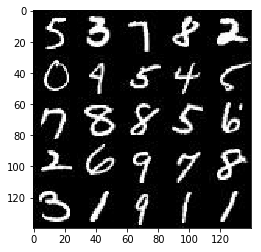

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

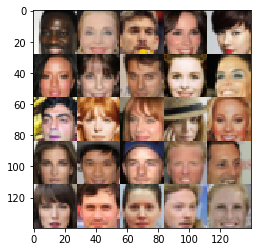

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    z_images = tf.placeholder(tf.float32, shape=(None, z_dim))
    lr = tf.placeholder(tf.float32)
    return real_images, z_images, lr

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


In [6]:
def leaky_relu(x, alpha=0.2):
    return tf.maximum(alpha*x, x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """

    with tf.variable_scope('discriminator', reuse=reuse):
        conv1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        act1 = leaky_relu(conv1, alpha)

        #input dims ==> (14, 14, 128)
        conv2 = tf.layers.conv2d(act1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv2)
        act2 = leaky_relu(bn2, alpha)

        #input dims ==> (7, 7, 256)
        conv3 = tf.layers.conv2d(act2, 512, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv3)
        act3 = leaky_relu(bn3, alpha)

        #input dims ==> (4, 4, 512)
        #conv4 = tf.layers.conv2d(act3, 1024, 5, strides=1, padding='same')
        #bn4 = tf.layers.batch_normalization(conv4)
        #act4 = leaky_relu(bn4, alpha)
        
        flat = tf.reshape(act3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    
    with tf.variable_scope('generator', reuse=(not is_train)):
        # First fully connected layer
        fc1 = tf.layers.dense(z, 7*7*512, activation=None)
        bn1 = tf.layers.batch_normalization(fc1, training=is_train)
        act1 = leaky_relu(bn1, alpha)
        proj1 = tf.reshape(act1, shape=(-1, 7, 7, 512))

        # input_dim ==> (7, 7, 512)
        conv1 = tf.layers.conv2d_transpose(proj1, 256, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(conv1, training=is_train)
        act2 = leaky_relu(bn2, alpha)

        # input_dim ==> (14, 14, 256)        
        conv2 = tf.layers.conv2d_transpose(act2, 128, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(conv2, training=is_train)
        act3 = leaky_relu(bn3, alpha)

        # input_dim ==> (28, 28, 256)        
        #conv3 = tf.layers.conv2d_transpose(act3, 128, 5, strides=1, padding='same')
        #bn4 = tf.layers.batch_normalization(conv3, training=is_train)
        #act4 = leaky_relu(bn4, alpha)

        # input_dim ==> (28, 28, 128)
        logits = tf.layers.conv2d_transpose(act3, out_channel_dim, 5, strides=1, padding='same')
        out = tf.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, 
                                                labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, 
                                                labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    steps = 0
    losses = []
    
    _, image_width, image_height, i_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height, i_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, i_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps +=1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                scaled_batch_images = batch_images * 2
                
                _ = sess.run(d_opt, feed_dict={lr: learning_rate, 
                                               input_real: scaled_batch_images, 
                                               input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={lr: learning_rate, 
                                               input_real: scaled_batch_images, 
                                               input_z: batch_z})
                
                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, 
                                                input_real: scaled_batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps % 100 == 0:
                    show_generator_output(sess, n_images=24, input_z=input_z,
                                          image_mode=data_image_mode, out_channel_dim=i_channels)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.0364... Generator Loss: 3.4009
Epoch 1/2... Discriminator Loss: 0.3426... Generator Loss: 1.2459
Epoch 1/2... Discriminator Loss: 0.1778... Generator Loss: 5.3531
Epoch 1/2... Discriminator Loss: 0.0815... Generator Loss: 5.0810
Epoch 1/2... Discriminator Loss: 0.1105... Generator Loss: 6.8931
Epoch 1/2... Discriminator Loss: 0.1365... Generator Loss: 7.7148
Epoch 1/2... Discriminator Loss: 0.2481... Generator Loss: 6.6385
Epoch 1/2... Discriminator Loss: 0.0367... Generator Loss: 7.3105
Epoch 1/2... Discriminator Loss: 0.5502... Generator Loss: 7.5368
Epoch 1/2... Discriminator Loss: 0.0125... Generator Loss: 6.5444


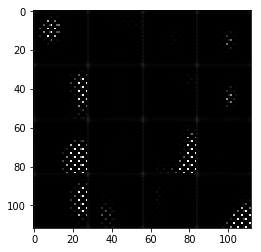

Epoch 1/2... Discriminator Loss: 0.5135... Generator Loss: 5.2014
Epoch 1/2... Discriminator Loss: 0.2935... Generator Loss: 4.1300
Epoch 1/2... Discriminator Loss: 0.3294... Generator Loss: 2.9473
Epoch 1/2... Discriminator Loss: 0.4090... Generator Loss: 3.1593
Epoch 1/2... Discriminator Loss: 0.8499... Generator Loss: 1.9645
Epoch 1/2... Discriminator Loss: 1.2869... Generator Loss: 0.9387
Epoch 1/2... Discriminator Loss: 1.1622... Generator Loss: 1.1127
Epoch 1/2... Discriminator Loss: 0.9794... Generator Loss: 1.0555
Epoch 1/2... Discriminator Loss: 1.5526... Generator Loss: 0.9395
Epoch 1/2... Discriminator Loss: 0.9347... Generator Loss: 0.9682


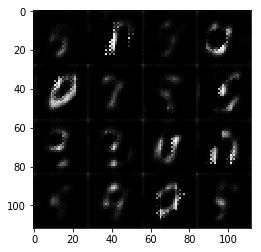

Epoch 1/2... Discriminator Loss: 1.1030... Generator Loss: 0.9207
Epoch 1/2... Discriminator Loss: 1.1752... Generator Loss: 1.0925
Epoch 1/2... Discriminator Loss: 1.0689... Generator Loss: 1.1376
Epoch 2/2... Discriminator Loss: 1.1765... Generator Loss: 0.9180
Epoch 2/2... Discriminator Loss: 1.2868... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.2072... Generator Loss: 0.7630
Epoch 2/2... Discriminator Loss: 1.2804... Generator Loss: 1.4479
Epoch 2/2... Discriminator Loss: 1.4873... Generator Loss: 0.5513
Epoch 2/2... Discriminator Loss: 0.9175... Generator Loss: 1.1153
Epoch 2/2... Discriminator Loss: 1.1381... Generator Loss: 0.8983


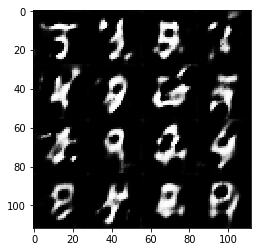

Epoch 2/2... Discriminator Loss: 1.0334... Generator Loss: 0.8732
Epoch 2/2... Discriminator Loss: 0.9650... Generator Loss: 0.9947
Epoch 2/2... Discriminator Loss: 1.0703... Generator Loss: 1.2815
Epoch 2/2... Discriminator Loss: 1.0683... Generator Loss: 0.8404
Epoch 2/2... Discriminator Loss: 1.0758... Generator Loss: 0.9541
Epoch 2/2... Discriminator Loss: 1.0706... Generator Loss: 0.9851
Epoch 2/2... Discriminator Loss: 1.1325... Generator Loss: 1.1236
Epoch 2/2... Discriminator Loss: 1.0562... Generator Loss: 0.9404
Epoch 2/2... Discriminator Loss: 1.2370... Generator Loss: 1.5371
Epoch 2/2... Discriminator Loss: 1.0270... Generator Loss: 1.1190


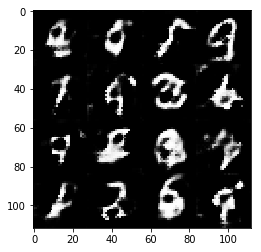

Epoch 2/2... Discriminator Loss: 1.0537... Generator Loss: 1.3846
Epoch 2/2... Discriminator Loss: 1.0865... Generator Loss: 0.7484
Epoch 2/2... Discriminator Loss: 1.0408... Generator Loss: 1.4659
Epoch 2/2... Discriminator Loss: 1.0898... Generator Loss: 1.0547
Epoch 2/2... Discriminator Loss: 1.0653... Generator Loss: 1.1532
Epoch 2/2... Discriminator Loss: 1.2187... Generator Loss: 0.5220


In [13]:
batch_size = 256
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5702... Generator Loss: 2.0909
Epoch 1/1... Discriminator Loss: 0.0423... Generator Loss: 6.0111
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 9.6997
Epoch 1/1... Discriminator Loss: 0.1191... Generator Loss: 10.9736
Epoch 1/1... Discriminator Loss: 0.2943... Generator Loss: 6.0308
Epoch 1/1... Discriminator Loss: 0.1783... Generator Loss: 4.4316
Epoch 1/1... Discriminator Loss: 0.2458... Generator Loss: 4.4644
Epoch 1/1... Discriminator Loss: 0.1306... Generator Loss: 6.6171
Epoch 1/1... Discriminator Loss: 0.4808... Generator Loss: 4.2473
Epoch 1/1... Discriminator Loss: 0.4931... Generator Loss: 2.9376


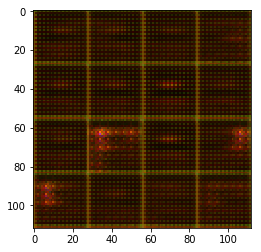

Epoch 1/1... Discriminator Loss: 0.4704... Generator Loss: 2.6398
Epoch 1/1... Discriminator Loss: 0.4824... Generator Loss: 3.0838
Epoch 1/1... Discriminator Loss: 1.6369... Generator Loss: 0.4224
Epoch 1/1... Discriminator Loss: 0.6056... Generator Loss: 3.7900
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.4475
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 0.9771... Generator Loss: 0.9563
Epoch 1/1... Discriminator Loss: 1.0529... Generator Loss: 1.4208
Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.0286... Generator Loss: 0.9162


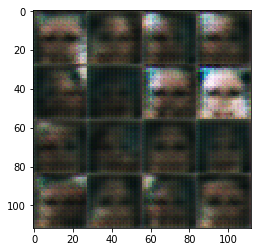

Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.6911
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.8037
Epoch 1/1... Discriminator Loss: 1.1302... Generator Loss: 0.7502
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6834
Epoch 1/1... Discriminator Loss: 1.3703... Generator Loss: 0.7597
Epoch 1/1... Discriminator Loss: 1.2647... Generator Loss: 0.7151
Epoch 1/1... Discriminator Loss: 1.2107... Generator Loss: 0.8461
Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.7677
Epoch 1/1... Discriminator Loss: 1.1477... Generator Loss: 0.9184
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.8481


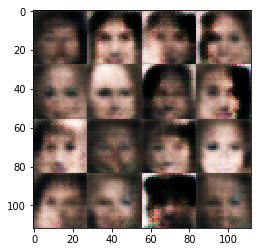

Epoch 1/1... Discriminator Loss: 0.7982... Generator Loss: 1.4934
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.0605
Epoch 1/1... Discriminator Loss: 1.1057... Generator Loss: 1.2507
Epoch 1/1... Discriminator Loss: 1.1255... Generator Loss: 1.0700
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 1.3143
Epoch 1/1... Discriminator Loss: 0.9670... Generator Loss: 1.1708
Epoch 1/1... Discriminator Loss: 1.0527... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 0.6721... Generator Loss: 3.0208
Epoch 1/1... Discriminator Loss: 0.7422... Generator Loss: 2.0486
Epoch 1/1... Discriminator Loss: 1.0736... Generator Loss: 1.0760


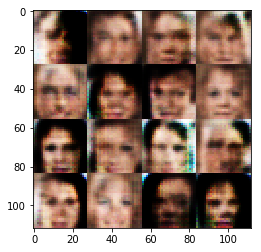

Epoch 1/1... Discriminator Loss: 0.9185... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 1.2434... Generator Loss: 2.6053
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.9733
Epoch 1/1... Discriminator Loss: 1.0634... Generator Loss: 1.1565
Epoch 1/1... Discriminator Loss: 1.1056... Generator Loss: 1.0377
Epoch 1/1... Discriminator Loss: 1.3302... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.0400... Generator Loss: 1.0185
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8368
Epoch 1/1... Discriminator Loss: 1.3151... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 0.9981... Generator Loss: 1.1769


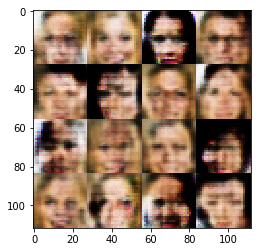

Epoch 1/1... Discriminator Loss: 1.1933... Generator Loss: 0.8126
Epoch 1/1... Discriminator Loss: 0.9852... Generator Loss: 1.0306
Epoch 1/1... Discriminator Loss: 1.2907... Generator Loss: 1.0801
Epoch 1/1... Discriminator Loss: 1.1026... Generator Loss: 1.0917
Epoch 1/1... Discriminator Loss: 1.1896... Generator Loss: 0.9486
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.4230
Epoch 1/1... Discriminator Loss: 1.0422... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.1778... Generator Loss: 1.0747
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.8453


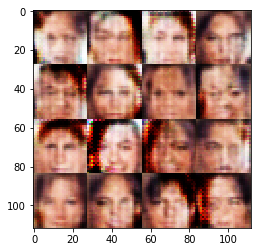

Epoch 1/1... Discriminator Loss: 1.1199... Generator Loss: 0.9010
Epoch 1/1... Discriminator Loss: 1.2466... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.3478... Generator Loss: 1.2604
Epoch 1/1... Discriminator Loss: 1.1098... Generator Loss: 1.1413
Epoch 1/1... Discriminator Loss: 1.0489... Generator Loss: 1.0602
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.9856
Epoch 1/1... Discriminator Loss: 1.1799... Generator Loss: 0.7295
Epoch 1/1... Discriminator Loss: 1.2868... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.2112... Generator Loss: 0.9249
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.5534


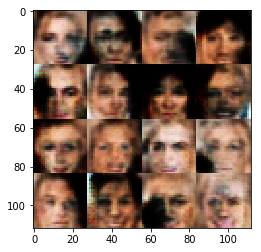

Epoch 1/1... Discriminator Loss: 1.2679... Generator Loss: 0.9597
Epoch 1/1... Discriminator Loss: 1.0434... Generator Loss: 1.2757
Epoch 1/1... Discriminator Loss: 1.1783... Generator Loss: 0.8141
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 1.1124
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.5596
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.3033... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.0337... Generator Loss: 1.0945
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 1.9436
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 1.5684


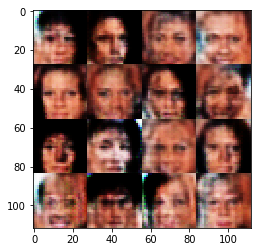

Epoch 1/1... Discriminator Loss: 1.1144... Generator Loss: 1.0342
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 0.9147
Epoch 1/1... Discriminator Loss: 1.1355... Generator Loss: 1.0219
Epoch 1/1... Discriminator Loss: 1.1599... Generator Loss: 1.0604
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 1.0453
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.8219
Epoch 1/1... Discriminator Loss: 1.2602... Generator Loss: 1.3267
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.5364
Epoch 1/1... Discriminator Loss: 1.1399... Generator Loss: 0.8358
Epoch 1/1... Discriminator Loss: 1.3203... Generator Loss: 0.8462


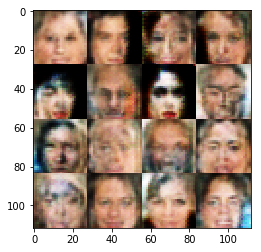

Epoch 1/1... Discriminator Loss: 0.9648... Generator Loss: 1.3802
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.8475
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 1.1943
Epoch 1/1... Discriminator Loss: 1.0438... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.3267... Generator Loss: 1.1283
Epoch 1/1... Discriminator Loss: 1.1701... Generator Loss: 1.3605
Epoch 1/1... Discriminator Loss: 1.0662... Generator Loss: 1.1510
Epoch 1/1... Discriminator Loss: 0.9230... Generator Loss: 1.1756
Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 0.7822... Generator Loss: 2.6680


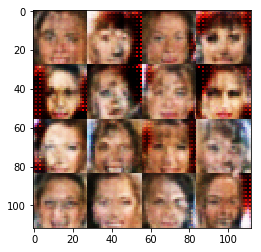

Epoch 1/1... Discriminator Loss: 1.0773... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.0854... Generator Loss: 0.9607
Epoch 1/1... Discriminator Loss: 1.2793... Generator Loss: 1.0517
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 1.1797
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7390
Epoch 1/1... Discriminator Loss: 1.1626... Generator Loss: 0.9007
Epoch 1/1... Discriminator Loss: 1.0111... Generator Loss: 1.0977
Epoch 1/1... Discriminator Loss: 1.1318... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 1.0304
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 2.1211


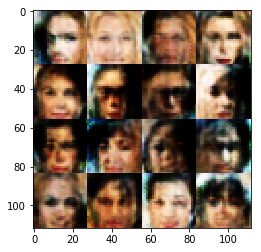

Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.7673
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.9293
Epoch 1/1... Discriminator Loss: 1.0602... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 1.3347
Epoch 1/1... Discriminator Loss: 1.0936... Generator Loss: 0.9751
Epoch 1/1... Discriminator Loss: 1.0479... Generator Loss: 1.2118
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.1774... Generator Loss: 0.8910
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 1.0478
Epoch 1/1... Discriminator Loss: 1.1174... Generator Loss: 1.0813


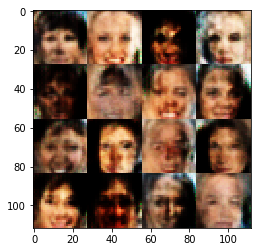

Epoch 1/1... Discriminator Loss: 1.1137... Generator Loss: 1.2087
Epoch 1/1... Discriminator Loss: 0.9152... Generator Loss: 2.1472
Epoch 1/1... Discriminator Loss: 0.9279... Generator Loss: 3.3364
Epoch 1/1... Discriminator Loss: 1.0144... Generator Loss: 1.1344
Epoch 1/1... Discriminator Loss: 1.0394... Generator Loss: 1.0311
Epoch 1/1... Discriminator Loss: 1.0793... Generator Loss: 0.9425
Epoch 1/1... Discriminator Loss: 1.0595... Generator Loss: 1.0903
Epoch 1/1... Discriminator Loss: 1.1018... Generator Loss: 0.8351
Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.0073
Epoch 1/1... Discriminator Loss: 1.1034... Generator Loss: 0.8505


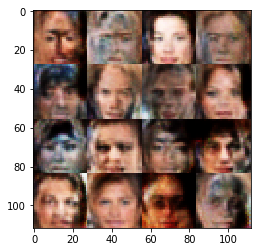

Epoch 1/1... Discriminator Loss: 1.1227... Generator Loss: 0.9307
Epoch 1/1... Discriminator Loss: 1.0957... Generator Loss: 1.0684
Epoch 1/1... Discriminator Loss: 1.1042... Generator Loss: 0.8418
Epoch 1/1... Discriminator Loss: 1.0625... Generator Loss: 1.0457
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 1.2037
Epoch 1/1... Discriminator Loss: 1.2573... Generator Loss: 0.6590
Epoch 1/1... Discriminator Loss: 1.8276... Generator Loss: 2.6024
Epoch 1/1... Discriminator Loss: 1.1685... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 0.9783
Epoch 1/1... Discriminator Loss: 1.1829... Generator Loss: 1.1607


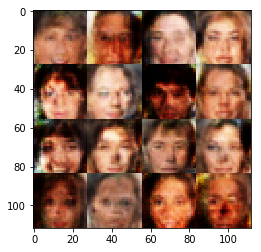

Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 1.6869
Epoch 1/1... Discriminator Loss: 1.1721... Generator Loss: 0.9623
Epoch 1/1... Discriminator Loss: 1.1412... Generator Loss: 1.1555
Epoch 1/1... Discriminator Loss: 1.0870... Generator Loss: 1.2453
Epoch 1/1... Discriminator Loss: 1.0246... Generator Loss: 1.3083
Epoch 1/1... Discriminator Loss: 1.2567... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 0.9374... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 0.8634... Generator Loss: 1.3231
Epoch 1/1... Discriminator Loss: 1.0559... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 1.0468


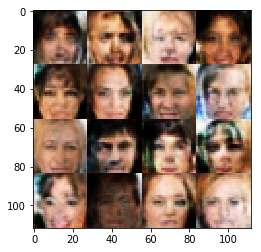

Epoch 1/1... Discriminator Loss: 0.7650... Generator Loss: 2.7727
Epoch 1/1... Discriminator Loss: 1.0228... Generator Loss: 1.2250
Epoch 1/1... Discriminator Loss: 1.2031... Generator Loss: 1.3278
Epoch 1/1... Discriminator Loss: 1.1989... Generator Loss: 1.1253
Epoch 1/1... Discriminator Loss: 1.0280... Generator Loss: 1.1159
Epoch 1/1... Discriminator Loss: 1.0121... Generator Loss: 1.2493
Epoch 1/1... Discriminator Loss: 1.1682... Generator Loss: 0.9310
Epoch 1/1... Discriminator Loss: 1.0125... Generator Loss: 0.9240


In [14]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.